In [ ]:
import pandas as pd
import numpy as np
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.models import Sequential
from keras.optimizers import SGD
from keras.losses import Huber
from keras.callbacks import Callback
import matplotlib.pyplot as plt
import tensorflow as tf 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('AAPL.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10468 entries, 0 to 10467
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10468 non-null  object 
 1   Open       10468 non-null  float64
 2   High       10468 non-null  float64
 3   Low        10468 non-null  float64
 4   Close      10468 non-null  float64
 5   Adj Close  10468 non-null  float64
 6   Volume     10468 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 572.6+ KB


In [ ]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100178,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094952,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087983,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090160,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092774,73449600
...,...,...,...,...,...,...,...
10463,2022-06-13,132.869995,135.199997,131.440002,131.880005,131.880005,122207100
10464,2022-06-14,133.130005,133.889999,131.479996,132.759995,132.759995,84784300
10465,2022-06-15,134.289993,137.339996,132.160004,135.429993,135.429993,91533000
10466,2022-06-16,132.080002,132.389999,129.039993,130.059998,130.059998,108123900


Text(0.5, 1.0, 'Average Price')

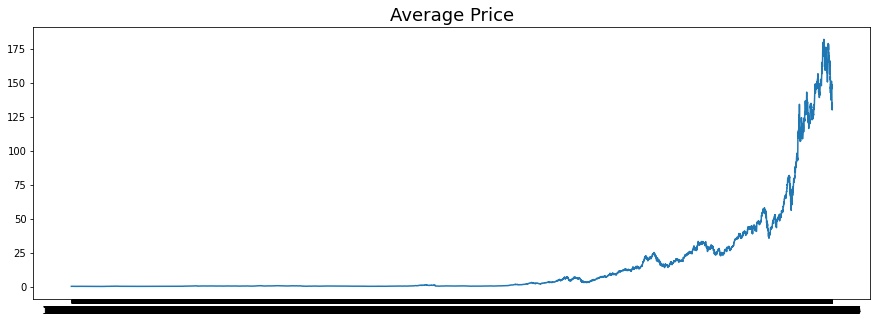

In [ ]:
dates = df['Date']
prices = df['Close']

plt.figure(figsize=(15,5))
plt.plot(dates, prices)
plt.title('Average Price', fontsize=18)

# Preprocessing

In [ ]:
X = df['Close'].values
y = df['Date'].values

In [ ]:
X

array([1.28348000e-01, 1.21652000e-01, 1.12723000e-01, ...,
       1.35429993e+02, 1.30059998e+02, 1.31559998e+02])

In [ ]:
min_max_scaler = MinMaxScaler()
X = X.reshape(-1, 1)
X = min_max_scaler.fit_transform(X)

In [ ]:
X = X.reshape(-1)
X

array([4.35483696e-04, 3.98684579e-04, 3.49613594e-04, ...,
       7.44010911e-01, 7.14499102e-01, 7.22742631e-01])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
X_train.shape

(8374,)

# Modeling

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size+1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [ ]:
X_train = windowed_dataset(X_train, window_size=64, batch_size=100, shuffle_buffer=1000)

In [ ]:
X_test = windowed_dataset(X_test, window_size=64, batch_size=100, shuffle_buffer=1000)

In [ ]:
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True)),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(
    optimizer=SGD(learning_rate=0.001, momentum=0.7),
    loss=Huber(),
    metrics=['accuracy', 'mae']
)

In [ ]:
threshold_mae = (X.max() - X.min()) * 10/100

In [ ]:
threshold_mae

0.09999999999999998

In [ ]:
class SelfCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
       if(logs.get('mae') < threshold_mae):      
          self.model.stop_training = True

In [ ]:
history = model.fit(X_train, validation_data=(X_test), callbacks=[SelfCallback()], epochs=500)

Epoch 1/500
84/84 [==============================] - 22s 204ms/step - loss: 0.1130 - accuracy: 1.2034e-04 - mae: 0.4743 - val_loss: 0.0391 - val_accuracy: 0.0000e+00 - val_mae: 0.2634
Epoch 2/500
84/84 [==============================] - 17s 192ms/step - loss: 0.1025 - accuracy: 1.2034e-04 - mae: 0.4515 - val_loss: 0.0366 - val_accuracy: 0.0000e+00 - val_mae: 0.2518
Epoch 3/500
84/84 [==============================] - 16s 193ms/step - loss: 0.0930 - accuracy: 1.2034e-04 - mae: 0.4299 - val_loss: 0.0347 - val_accuracy: 0.0000e+00 - val_mae: 0.2414
Epoch 4/500
84/84 [==============================] - 17s 197ms/step - loss: 0.0843 - accuracy: 1.2034e-04 - mae: 0.4091 - val_loss: 0.0333 - val_accuracy: 0.0000e+00 - val_mae: 0.2319
Epoch 5/500
84/84 [==============================] - 17s 199ms/step - loss: 0.0759 - accuracy: 1.2034e-04 - mae: 0.3877 - val_loss: 0.0324 - val_accuracy: 0.0000e+00 - val_mae: 0.2230
Epoch 6/500
84/84 [==============================] - 18s 214ms/step - loss: 0.06

# Plotting

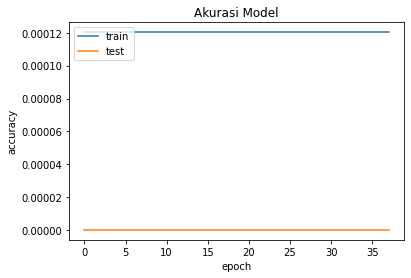

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

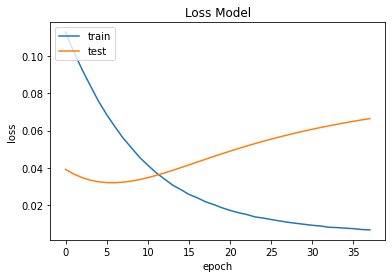

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()